# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from numpy import random 
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

from bs4 import BeautifulSoup


import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from sklearn.metrics import roc_curve,accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# using SQLite Table to read data.

con = sqlite3.connect('drive/My Drive/FFRDB/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [ ]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [ ]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [ ]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [ ]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [ ]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [ ]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [ ]:
final.sort_values('Time',inplace=True)
print(final.head(5))

            Id  ...                                               Text
138706  150524  ...  this witty little book makes my son laugh at l...
138683  150501  ...  I can remember seeing the show when it aired o...
417839  451856  ...  Beetlejuice is a well written movie ..... ever...
346055  374359  ...  A twist of rumplestiskin captured on film, sta...
417838  451855  ...  Beetlejuice is an excellent and funny movie. K...

[5 rows x 10 columns]


In [ ]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [ ]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [ ]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [ ]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [ ]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I finally ordered a couple products from this seller for myself(not as gifts) and I am really happy. This Jade Bonsai is really cool and it arrived fast and in perfect condition. It's in my living room and I get tons of compliments. It's already grown some too and the pot it came in is really nice, looks expensive! Much bigger than I thought it would be even.  Thanks again!!
I bought some of this tea when I was in Seattle and I have been dying to get more.  It really is the best tea I have ever had.  It is great hot or cold.
I would prefer freshly made brown rice, but that takes a long time to make and isn't easy. Th

In [ ]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [ ]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I finally ordered a couple products from this seller for myself(not as gifts) and I am really happy. This Jade Bonsai is really cool and it arrived fast and in perfect condition. It's in my living room and I get tons of compliments. It's already grown some too and the pot it came in is really nice, looks expensive! Much bigger than I thought it would be even.  Thanks again!!
I bought some of this tea when I was in Seattle and I have been dying to get more.  It really is the best tea I have ever had.  It is great hot or cold.
I would prefer freshly made brown rice, but that takes a long time to make and isn't easy. Th

In [ ]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [ ]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

I bought some of this tea when I was in Seattle and I have been dying to get more.  It really is the best tea I have ever had.  It is great hot or cold.


In [ ]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [ ]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

I bought some of this tea when I was in Seattle and I have been dying to get more It really is the best tea I have ever had It is great hot or cold 


In [ ]:
final=final.sample(40000,random_state=23)

In [ ]:
# Combining all the above stundents 
from tqdm.notebook import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split())
    preprocessed_reviews.append(sentance.strip())

In [ ]:
preprocessed_reviews[1500]

'i think i am a granola expert i have tried many and let me tell you this is the best with certified organic ingredients ambrosial granola grecian grove antioxidant blend delivers nutrition and great taste i like the fact that every spoonfull is loaded with organic fruits there is no added fat and is lightely sweetened with healthy sweeteners like honey molasses and rice syrup all good for you sweeteners ambrosial product'

# Vectorizing sentences for LSTM input

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(preprocessed_reviews,final['Score'].values,test_size=0.3,random_state=0)

In [ ]:
def concat(list):
    from tqdm.notebook import tqdm
    op= ' '
    print("making a Bag of words")
    for ele in tqdm(list):
        op = op + ' '+ str(ele)
    return op.split(' ')

In [ ]:
# def fit(lst,top_word):
#   from tqdm.notebook import tqdm
#   corpus=[]
#   corpus=concat(lst)
#   print('generating word frequncy dictionry')
#   freq = [corpus.count(p) for p in tqdm(corpus)]
#   dic=dict(list(zip(corpus,freq)))
#   arr = [list(dic.items()) for d in dic]
#   print('returning word frequncy dataframe')
#   return pd.DataFrame(arr[0], columns=['word', 'freq']).sort_values(by=['freq'], ascending=False,ignore_index=True).head(top_word)

In [ ]:
# def fit(lst,top_word):
#   from tqdm.notebook import tqdm
#   import itertools
#   corpus=[]
#   dic={}
#   corpus=concat(lst)
#   print('generating word frequncy dictionry')
  
#   for p in tqdm(corpus):
#     freq=0
#     if p in dic.keys():
#       pass
#     else:
#       freq=(corpus.count(p))
#       dic[p]=freq
#   sort_orders = dict(sorted(dic.items(), key=lambda x: x[1], reverse=True))
#   out = dict(itertools.islice(sort_orders.items(), top_word))
#   print('returning word frequncy dataframe')
#   return pd.DataFrame([out])

In [ ]:
def fit(lst,top_word):
  from tqdm.notebook import tqdm
  import itertools
  corpus=[]
  dic={}
  corpus=concat(lst)
  print('generating word frequency dictionry')
  
  for p in tqdm(corpus):
    freq=0
    if p in dic.keys():
      pass
    else:
      freq=(corpus.count(p))
      dic[p]=freq
  sort_orders = dict(sorted(dic.items(), key=lambda x: x[1], reverse=True))
  print('dictionary sorted')

  out = dict(itertools.islice(sort_orders.items(), top_word))
  print('top {} words extracted'.format(top_word))

  arr = list(out.keys())
  print('returnig dataframe')
  return np.array(arr)

In [ ]:
def transform(lst,fit):
  doc=[]
  from tqdm.notebook import tqdm
  fit=fit.tolist()
  print('generating document list containing sentance list in vetor form')
  for sent in tqdm(lst):
    sent_vect=[]
    for word in sent.split(' '):
      try:
            idx = fit.index(str(word))+1
      except:
            idx = 0
      sent_vect.append(idx)
    doc.append(sent_vect)
  return doc

In [ ]:
print(type(X_train[9]))
print(len(X_train[9].split(' ')))
print(X_train[9])

<class 'str'>
33
bought these regularly from the vending machine at college until of course they stopped stocking them why i do not know i was happy to find them at amazon and bought a case


In [ ]:
print(type(X_train[1]))
print(len(X_train[1].split(' ')))
print(X_train[0])

<class 'str'>
47
my husband is a huge root beer fan so i got him this for christmas the root beer was good but with shipping it comes to a lot of money after i ordered i found out you can actually get all of these brands at cost plus for much cheaper since you do not have to pay for shipping


In [ ]:
print(type(X_train[24]))
print(len(X_train[24].split(' ')))
print(X_train[24])

<class 'str'>
22
light n fluffy less hulls than most interesting light bluish tint to the poppped corn love the convenience of the microwave bags


In [ ]:
ts_lst=[X_train[1],X_train[9],X_train[24]]

In [ ]:
ts=concat(ts_lst)
print(len(ts))
print(ts)

making a Bag of words



104
['', '', 'enjoyed', 'making', 'those', 'cookies', 'with', 'my', 'two', 'girls', 'and', 'yo', 'they', 'enjoyed', 'cracking', 'egg', 'and', 'mixing', 'it', 'then', 'watching', 'it', 'to', 'shape', 'up', 'and', 'get', 'ready', 'easy', 'to', 'make', 'fast', 'to', 'prepare', 'and', 'really', 'tasty', 'also', 'makes', 'a', 'good', 'project', 'for', 'kids', 'when', 'they', 'have', 'friends', 'over', 'bought', 'these', 'regularly', 'from', 'the', 'vending', 'machine', 'at', 'college', 'until', 'of', 'course', 'they', 'stopped', 'stocking', 'them', 'why', 'i', 'do', 'not', 'know', 'i', 'was', 'happy', 'to', 'find', 'them', 'at', 'amazon', 'and', 'bought', 'a', 'case', 'light', 'n', 'fluffy', 'less', 'hulls', 'than', 'most', 'interesting', 'light', 'bluish', 'tint', 'to', 'the', 'poppped', 'corn', 'love', 'the', 'convenience', 'of', 'the', 'microwave', 'bags']


In [ ]:
X=fit(ts_lst,50)

making a Bag of words



generating word frequency dictionry



dictionary sorted
top 50 words extracted
returnig dataframe


In [ ]:
X

array(['and', 'to', 'the', 'they', '', 'enjoyed', 'it', 'a', 'bought',
       'at', 'of', 'them', 'i', 'light', 'making', 'those', 'cookies',
       'with', 'my', 'two', 'girls', 'yo', 'cracking', 'egg', 'mixing',
       'then', 'watching', 'shape', 'up', 'get', 'ready', 'easy', 'make',
       'fast', 'prepare', 'really', 'tasty', 'also', 'makes', 'good',
       'project', 'for', 'kids', 'when', 'have', 'friends', 'over',
       'these', 'regularly', 'from'], dtype='<U9')

In [ ]:
y=transform(ts_lst,X)

generating document list containing sentance list in vetor form


In [ ]:
for i in y:
  print(i)

[6, 15, 16, 17, 18, 19, 20, 21, 1, 22, 4, 6, 23, 24, 1, 25, 7, 26, 27, 7, 2, 28, 29, 1, 30, 31, 32, 2, 33, 34, 2, 35, 1, 36, 37, 38, 39, 8, 40, 41, 42, 43, 44, 4, 45, 46, 47]
[9, 48, 49, 50, 3, 0, 0, 10, 0, 0, 11, 0, 4, 0, 0, 12, 0, 13, 0, 0, 0, 13, 0, 0, 2, 0, 12, 10, 0, 1, 9, 8, 0]
[14, 0, 0, 0, 0, 0, 0, 0, 14, 0, 0, 2, 3, 0, 0, 0, 3, 0, 11, 3, 0, 0]


In [ ]:
for i in ts_lst:
  print(i)

enjoyed making those cookies with my two girls and yo they enjoyed cracking egg and mixing it then watching it to shape up and get ready easy to make fast to prepare and really tasty also makes a good project for kids when they have friends over
bought these regularly from the vending machine at college until of course they stopped stocking them why i do not know i was happy to find them at amazon and bought a case
light n fluffy less hulls than most interesting light bluish tint to the poppped corn love the convenience of the microwave bags


In [ ]:
new_lst=X_train[1000:1005]

In [ ]:
y=transform(new_lst,X)

generating document list containing sentance list in vetor form


In [ ]:
for i in y:
  print(i)

[13, 0, 0, 0, 8, 0, 0, 13, 0, 0, 0, 7, 0, 0, 13, 0, 0, 0, 19, 46, 0, 0, 0, 0, 4, 0, 7, 7, 0, 0, 3, 0, 7, 0, 7, 0]
[13, 0, 3, 0, 0, 0, 0, 1, 13, 0, 13, 0, 0, 0, 8, 0, 0, 0, 30, 0, 3, 0, 42, 3, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 3, 0, 13, 0, 2, 0, 0, 0, 0, 2, 0, 0, 19, 0, 0, 0, 39, 7, 0, 0, 0, 3, 0, 0, 3, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 42, 3, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0]
[0, 0, 0, 44, 7, 0, 0, 0, 0, 0, 0, 42, 7, 0, 3, 0, 0, 0, 3, 0, 0, 7, 0, 0, 42, 0, 0, 0, 40, 0, 7, 0, 42, 0, 0, 18, 8, 0, 0, 0, 0, 0, 0, 7, 0, 8, 0, 11, 0, 0, 0, 0, 0, 7, 3, 0, 20, 0, 0, 0, 1, 3, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 11, 0, 0, 3, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 11, 0, 0, 0, 18, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 7, 0, 0, 40, 42, 0, 7, 0, 0, 3, 0, 0, 0, 15, 0, 0, 0, 13, 0, 13, 0, 0, 42, 0, 0, 1, 0, 0, 0, 3, 0, 11, 3, 0, 13, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 19, 0, 0, 13, 0, 0, 8, 0, 42, 0, 0, 44, 0, 0, 29, 13, 0, 0, 0, 2, 0, 3, 0, 0, 13, 0, 

In [ ]:
for i in new_lst:
  print(i)

i sent this as a gift so i cannot comment on it too much i do know that my friends were very pleased once they received it it arrived on the date it said it would
i use the goita chitosuma yuzu juice and i thought i would give this a try because you get double the amount for the dollar well no you do not it is diluted weaker than the goita i had to use times as much to put in my ice water that makes it more expensive in the long run the goita is higher concentrate and one can use or less as much for the same effect either way it is all better than lemon
problem is ridiculous when it is in most grocery stores look for it in the spice aisle on the bottom shelf it is salt for cryin out loud good thing it qualifies for free shipping with a purchase problem description is wrong yes it is a pack of three pounds but that is it the next two items contradict themselves and the first one is wrong it does not contain iodine kosher salt by definition cannot contain iodine the anti caking agent is 

In [ ]:
fit_vect=fit(X_train,5000)

In [ ]:
# dbfile1 = open('/content/drive/My Drive/FFRDB/lstm.pkl', 'wb')
# pickle.dump(fit_vect, dbfile1)
# dbfile1.close()
dbfile1 = open('/content/drive/My Drive/FFRDB/lstm.pkl', 'rb')
fit_vect = pickle.load(dbfile1)

In [ ]:
fit_vect.shape

(5000,)

In [ ]:
X_train=transform(X_train,fit_vect)

generating document list containing sentance list in vetor form


In [ ]:
# dbfile1 = open('/content/drive/My Drive/FFRDB/lstm2.pkl', 'wb')
# pickle.dump([X_train,y_train], dbfile1)
# dbfile1.close()
dbfile1 = open('/content/drive/My Drive/FFRDB/lstm2.pkl', 'rb')
X_train,y_train = pickle.load(dbfile1)

In [ ]:
print(len(X_train))
print(len(y_train))

28000
28000


In [ ]:
X_test=transform(X_test,fit_vect)

generating document list containing sentance list in vetor form


In [ ]:
# dbfile1 = open('/content/drive/My Drive/FFRDB/lstm3.pkl', 'wb')
# pickle.dump([X_test,y_test], dbfile1)
# dbfile1.close()
dbfile1 = open('/content/drive/My Drive/FFRDB/lstm3.pkl', 'rb')
X_test,y_test = pickle.load(dbfile1)

In [ ]:
# Credits: https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/
# LSTM for sequence classification in the IMDB dataset
import numpy
# from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
numpy.random.seed(7)

Using TensorFlow backend.


In [ ]:
X_tr,y_tr=X_train,y_train

In [ ]:
X_ts=X_test
y_ts=y_test

In [ ]:
print(X_tr[1])
print(type(X_tr[1]))
print(len(X_tr[1]))
print(len(X_tr))

[499, 310, 219, 233, 17, 13, 119, 2671, 3, 0, 21, 499, 0, 1000, 3, 1094, 5, 110, 1576, 5, 7, 1036, 63, 3, 59, 823, 168, 7, 80, 399, 7, 1002, 3, 65, 218, 75, 152, 4, 28, 0, 12, 332, 49, 21, 15, 486, 121]
<class 'list'>
47
28000


In [ ]:
max_review_length = 200
X_tr = sequence.pad_sequences(X_tr, maxlen=max_review_length)
X_ts = sequence.pad_sequences(X_ts, maxlen=max_review_length)

In [ ]:
# truncate and/or pad input sequences
print(X_tr.shape)
print(X_tr[0])

(28000, 200)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0   13  346    6    4  540 1438 1368  460   24    2  153  304    9
   12  641    1 1438 1368   20   28   19   17  217    5  325    7    4
  171    8  323   93    2  188    2  107   56   16   32  245   59   41
    8   26  295   31  417  420   12   71  385  133   16   40   1

In [ ]:
# create the model
top_words=5000
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 200, 32)           160032    
_________________________________________________________________
lstm_14 (LSTM)               (None, 100)               53200     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 101       
Total params: 213,333
Trainable params: 213,333
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history=model.fit(X_tr, y_tr, validation_split=0.2,  nb_epoch=10, batch_size=64)

Train on 22400 samples, validate on 5600 samples
Epoch 1/10
22400/22400 [==============================] - 102s 5ms/step - loss: 0.3242 - accuracy: 0.8716 - val_loss: 0.2552 - val_accuracy: 0.8943
Epoch 2/10
22400/22400 [==============================] - 108s 5ms/step - loss: 0.1983 - accuracy: 0.9215 - val_loss: 0.2243 - val_accuracy: 0.9098
Epoch 3/10
22400/22400 [==============================] - 108s 5ms/step - loss: 0.1567 - accuracy: 0.9419 - val_loss: 0.2322 - val_accuracy: 0.9134
Epoch 4/10
22400/22400 [==============================] - 106s 5ms/step - loss: 0.1399 - accuracy: 0.9484 - val_loss: 0.2437 - val_accuracy: 0.9084
Epoch 5/10
22400/22400 [==============================] - 99s 4ms/step - loss: 0.1206 - accuracy: 0.9561 - val_loss: 0.2518 - val_accuracy: 0.9016
Epoch 6/10
22400/22400 [==============================] - 99s 4ms/step - loss: 0.1061 - accuracy: 0.9629 - val_loss: 0.2562 - val_accuracy: 0.9096
Epoch 7/10
22400/22400 [==============================] - 98s 4ms

In [ ]:
scores = model.evaluate(X_ts, y_ts, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 89.67%


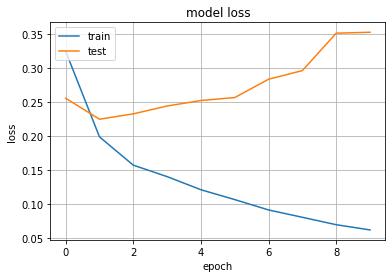

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# create the model
top_words=5000
embedding_vecor_length = 32
model2 = Sequential()
model2.add(Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length))
model2.add(LSTM(50))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model2.summary())
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 200, 32)           160032    
_________________________________________________________________
lstm_15 (LSTM)               (None, 50)                16600     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 51        
Total params: 176,683
Trainable params: 176,683
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history2=model2.fit(X_tr, y_tr, validation_split=0.2,  nb_epoch=10, batch_size=64)

Train on 22400 samples, validate on 5600 samples
Epoch 1/10
22400/22400 [==============================] - 56s 2ms/step - loss: 0.3388 - accuracy: 0.8643 - val_loss: 0.2486 - val_accuracy: 0.8950
Epoch 2/10
22400/22400 [==============================] - 55s 2ms/step - loss: 0.1979 - accuracy: 0.9206 - val_loss: 0.2261 - val_accuracy: 0.9084
Epoch 3/10
22400/22400 [==============================] - 54s 2ms/step - loss: 0.1536 - accuracy: 0.9417 - val_loss: 0.2458 - val_accuracy: 0.8957
Epoch 4/10
22400/22400 [==============================] - 54s 2ms/step - loss: 0.1304 - accuracy: 0.9513 - val_loss: 0.2394 - val_accuracy: 0.9096
Epoch 5/10
22400/22400 [==============================] - 54s 2ms/step - loss: 0.1185 - accuracy: 0.9565 - val_loss: 0.2521 - val_accuracy: 0.9093
Epoch 6/10
22400/22400 [==============================] - 55s 2ms/step - loss: 0.0978 - accuracy: 0.9655 - val_loss: 0.3133 - val_accuracy: 0.9102
Epoch 7/10
22400/22400 [==============================] - 55s 2ms/ste

In [ ]:
scores = model2.evaluate(X_ts, y_ts, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 90.13%


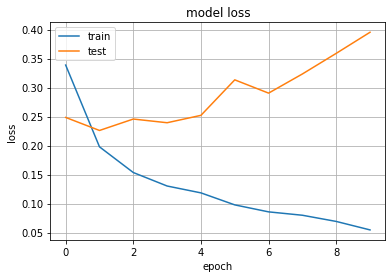

In [ ]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.grid()
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# create the model
top_words=5000
embedding_vecor_length = 32
model3 = Sequential()
model3.add(Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length))
model3.add(Dropout(0.3))
model3.add(LSTM(150))
model3.add(Dropout(0.3))
model3.add(Dense(1, activation='sigmoid'))
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model3.summary())
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 200, 32)           160032    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200, 32)           0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 150)               109800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 151       
Total params: 269,983
Trainable params: 269,983
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history3=model3.fit(X_tr, y_tr, validation_split=0.2,  nb_epoch=10, batch_size=64)

Train on 22400 samples, validate on 5600 samples
Epoch 1/10
22400/22400 [==============================] - 192s 9ms/step - loss: 0.3387 - accuracy: 0.8688 - val_loss: 0.2480 - val_accuracy: 0.9009
Epoch 2/10
22400/22400 [==============================] - 195s 9ms/step - loss: 0.2176 - accuracy: 0.9146 - val_loss: 0.2237 - val_accuracy: 0.9123
Epoch 3/10
22400/22400 [==============================] - 192s 9ms/step - loss: 0.1730 - accuracy: 0.9346 - val_loss: 0.2325 - val_accuracy: 0.9161
Epoch 4/10
22400/22400 [==============================] - 186s 8ms/step - loss: 0.1764 - accuracy: 0.9312 - val_loss: 0.2625 - val_accuracy: 0.9139
Epoch 5/10
22400/22400 [==============================] - 186s 8ms/step - loss: 0.1480 - accuracy: 0.9425 - val_loss: 0.2452 - val_accuracy: 0.9125
Epoch 6/10
22400/22400 [==============================] - 192s 9ms/step - loss: 0.1235 - accuracy: 0.9546 - val_loss: 0.2505 - val_accuracy: 0.9052
Epoch 7/10
22400/22400 [==============================] - 184s 

In [ ]:
scores = model3.evaluate(X_ts, y_ts, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 90.38%


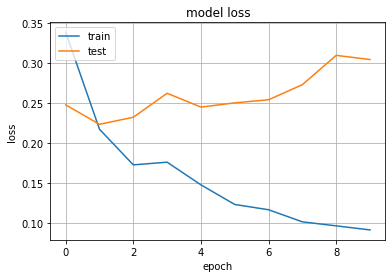

In [ ]:
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

In [ ]:
! pip install --upgrade keras

  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [ ]:
!pip uninstall tensorflow

Uninstalling tensorflow-1.13.2:
  Would remove:
    /usr/local/bin/freeze_graph
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-1.13.2.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-1.13.2


In [ ]:
! pip install tensorflow==2.2.0

     |████████████████████████████████| 516.2MB 32kB/s 
     |████████████████████████████████| 3.0MB 47.2MB/s 
     |████████████████████████████████| 460kB 46.0MB/s 
  Found existing installation: tensorboard 1.13.1
    Uninstalling tensorboard-1.13.1:
      Successfully uninstalled tensorboard-1.13.1
  Found existing installation: tensorflow-estimator 1.13.0
    Uninstalling tensorflow-estimator-1.13.0:
      Successfully uninstalled tensorflow-estimator-1.13.0


In [ ]:
# create the model
import tensorflow as tf
from tensorflow.keras.layers import Dense,Dropout,LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding



top_words=5000
embedding_vecor_length = 32

model4 = Sequential()
model4.add(Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length))
model4.add(Dropout(0.3))
model4.add(LSTM(128,return_sequences=True))
model4.add(Dropout(0.3))
model4.add(LSTM(32))
model4.add(Dropout(0.3))
model4.add(Dense(32,activation='relu'))
model4.add(Dense(1, activation='relu'))
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model4.summary())
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 32)           160032    
_________________________________________________________________
dropout_4 (Dropout)          (None, 200, 32)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 200, 128)          82432     
_________________________________________________________________
dropout_5 (Dropout)          (None, 200, 128)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                20608     
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)               

In [ ]:
history4=model4.fit(X_tr, y_tr, validation_split=0.2, epochs=100, batch_size=64)

Epoch 1/100
350/350 [==============================] - 9s 26ms/step - loss: 2.3543 - accuracy: 0.8243 - val_loss: 2.4018 - val_accuracy: 0.8425
Epoch 2/100
350/350 [==============================] - 9s 25ms/step - loss: 2.3575 - accuracy: 0.8454 - val_loss: 2.4018 - val_accuracy: 0.8425
Epoch 3/100
350/350 [==============================] - 9s 25ms/step - loss: 2.3575 - accuracy: 0.8454 - val_loss: 2.4018 - val_accuracy: 0.8425
Epoch 4/100
350/350 [==============================] - 9s 25ms/step - loss: 2.3575 - accuracy: 0.8454 - val_loss: 2.4018 - val_accuracy: 0.8425
Epoch 5/100
350/350 [==============================] - 9s 25ms/step - loss: 2.3575 - accuracy: 0.8454 - val_loss: 2.4018 - val_accuracy: 0.8425
Epoch 6/100
350/350 [==============================] - 9s 24ms/step - loss: 2.3575 - accuracy: 0.8454 - val_loss: 2.4018 - val_accuracy: 0.8425
Epoch 7/100
350/350 [==============================] - 9s 25ms/step - loss: 2.3575 - accuracy: 0.8454 - val_loss: 2.4018 - val_accuracy:

In [ ]:
scores = model4.evaluate(X_ts, y_ts, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 84.72%


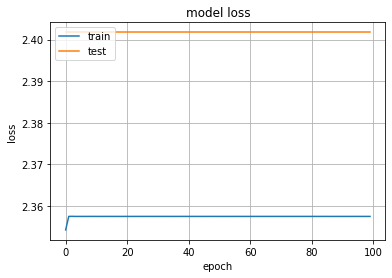

In [ ]:
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

In [78]:
# create the model
import tensorflow as tf
from tensorflow.keras.layers import Dense,Dropout,LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding

top_words=5000
embedding_vecor_length = 32

model5 = Sequential()
model5.add(Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length))
model5.add(Dropout(0.3))
model5.add(LSTM(128,return_sequences=True))
model5.add(Dropout(0.3))
model5.add(LSTM(64,return_sequences=True))
model5.add(Dropout(0.3))
model5.add(LSTM(32))
model5.add(Dropout(0.3))
model5.add(Dense(32,activation='relu'))
model5.add(Dense(1, activation='relu'))

model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model5.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 200, 32)           160032    
_________________________________________________________________
dropout_25 (Dropout)         (None, 200, 32)           0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 200, 128)          82432     
_________________________________________________________________
dropout_26 (Dropout)         (None, 200, 128)          0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 200, 64)           49408     
_________________________________________________________________
dropout_27 (Dropout)         (None, 200, 64)           0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 32)              

In [79]:
history5=model5.fit(X_tr, y_tr, validation_split=0.2, epochs=30, batch_size=64)

Epoch 1/30
350/350 [==============================] - 13s 36ms/step - loss: 0.8090 - accuracy: 0.7314 - val_loss: 0.4353 - val_accuracy: 0.8425
Epoch 2/30
350/350 [==============================] - 12s 33ms/step - loss: 0.5157 - accuracy: 0.8279 - val_loss: 0.4879 - val_accuracy: 0.8486
Epoch 3/30
350/350 [==============================] - 12s 33ms/step - loss: 0.4472 - accuracy: 0.8466 - val_loss: 0.5266 - val_accuracy: 0.8827
Epoch 4/30
350/350 [==============================] - 12s 33ms/step - loss: 0.3955 - accuracy: 0.8697 - val_loss: 0.5453 - val_accuracy: 0.8879
Epoch 5/30
350/350 [==============================] - 11s 33ms/step - loss: 0.3836 - accuracy: 0.8685 - val_loss: 0.3671 - val_accuracy: 0.8666
Epoch 6/30
350/350 [==============================] - 11s 33ms/step - loss: 0.3469 - accuracy: 0.8987 - val_loss: 0.5236 - val_accuracy: 0.8936
Epoch 7/30
350/350 [==============================] - 12s 33ms/step - loss: 0.4674 - accuracy: 0.7927 - val_loss: 0.8687 - val_accuracy:

In [80]:
scores = model5.evaluate(X_ts, y_ts, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 89.72%


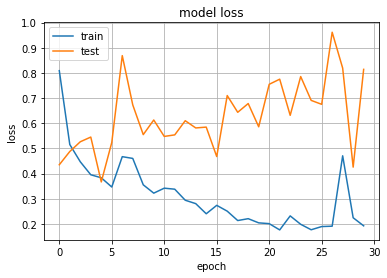

In [81]:
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

In [86]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["S.NO.", "architecture", "Epochs", "Test Accuracy"]
x.add_row(["1", "Keras LSTM(100)", "10","89.67%"])
x.add_row(["2", "Keras LSTM(50)","10","90.13%"])
x.add_row(["3", "Keras LSTM(50) + Dropouts", "10","90.38%"])
x.add_row(["4", "TenserFlow LSTM(128,32)+ Dense(32,1)+Dropouts","100","84.72%"])
x.add_row(["5", "TenserFlow LSTM(128,64,32)+ Dense(32,1)+Dropouts","30","89.72%"])
print(x)

+-------+--------------------------------------------------+--------+---------------+
| S.NO. |                   architecture                   | Epochs | Test Accuracy |
+-------+--------------------------------------------------+--------+---------------+
|   1   |                 Keras LSTM(100)                  |   10   |     89.67%    |
|   2   |                  Keras LSTM(50)                  |   10   |     90.13%    |
|   3   |            Keras LSTM(50) + Dropouts             |   10   |     90.38%    |
|   4   |  TenserFlow LSTM(128,32)+ Dense(32,1)+Dropouts   |  100   |     84.72%    |
|   5   | TenserFlow LSTM(128,64,32)+ Dense(32,1)+Dropouts |   30   |     89.72%    |
+-------+--------------------------------------------------+--------+---------------+
